# Importing Stuff

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import os

# Setting constants

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3

# Creating tf.dataset

In [3]:
apple_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "D:\College Stuff\TY\ML\MP\Dataset\Apple",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3171 files belonging to 4 classes.


In [4]:
class_names = apple_dataset.class_names
class_names

['Black_rot', 'Cedar_apple_rust', 'Healthy', 'Scab']

In [5]:
len(apple_dataset)

100

In [6]:
for image_batch, labels_batch in apple_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[3 0 0 2 1 0 2 2 0 2 2 3 2 2 2 2 2 2 3 2 2 2 2 2 3 2 2 3 2 2 3 0]


# Dataset Visualization

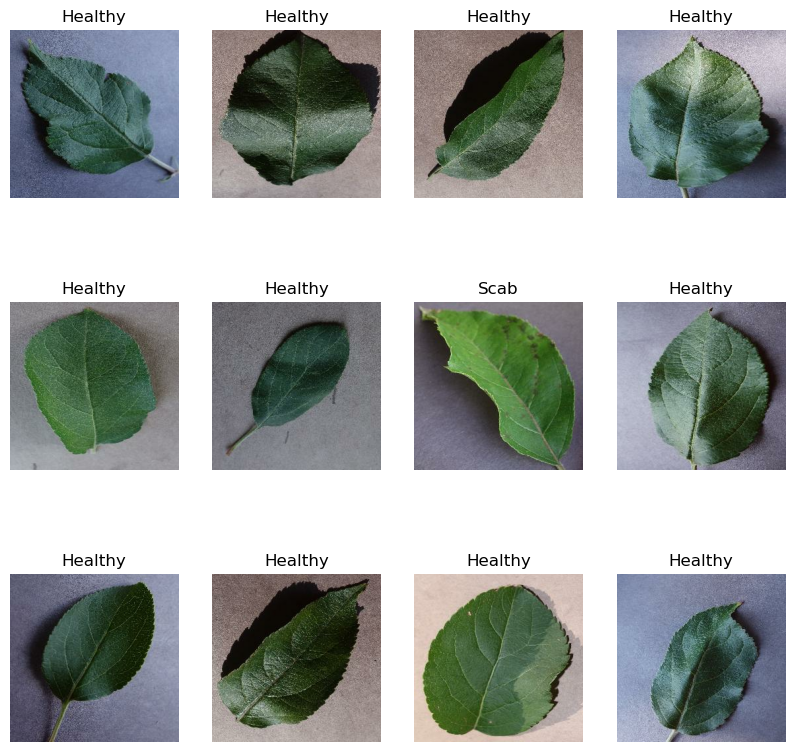

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in apple_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Train-Test Split

In [8]:
len(apple_dataset)

100

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=False):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
apple_train, apple_val, apple_test = get_dataset_partitions_tf(apple_dataset)

In [11]:
len(apple_dataset), len(apple_train), len(apple_val), len(apple_test)

(100, 80, 10, 10)

### Cache Suffle Prefetch

In [12]:
train_ds = apple_train.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = apple_val.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = apple_test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Resizing, Rescaling

In [13]:
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
])

In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [15]:
apple_train = apple_train.map(
    lambda x, y: (data_augmentation(x, training=True), y)
)

In [16]:
apple_train = apple_train.map(
    lambda x, y: (resize_and_rescale(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

Model: CNN

In [17]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [18]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### Compiling the model

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
class TrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if logs.get('accuracy') > 0.99:
            print('The model has reached the accuracy desired (0.99), stop the training!')
            self.model.stop_training = True

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
    callbacks = TrainingCallback()
)

Epoch 1/30
80/80 [==============================] - 160s 2s/step - loss: 0.9039 - accuracy: 0.6410 - val_loss: 0.5794 - val_accuracy: 0.7594
Epoch 2/30
80/80 [==============================] - 137s 2s/step - loss: 0.5281 - accuracy: 0.8203 - val_loss: 0.4546 - val_accuracy: 0.8313
Epoch 3/30
80/80 [==============================] - 158s 2s/step - loss: 0.4337 - accuracy: 0.8527 - val_loss: 0.3971 - val_accuracy: 0.8438
Epoch 4/30
80/80 [==============================] - 160s 2s/step - loss: 0.3379 - accuracy: 0.8820 - val_loss: 0.4629 - val_accuracy: 0.8250
Epoch 5/30
80/80 [==============================] - 135s 2s/step - loss: 0.2815 - accuracy: 0.9027 - val_loss: 0.2109 - val_accuracy: 0.9187
Epoch 6/30
80/80 [==============================] - 136s 2s/step - loss: 0.2420 - accuracy: 0.9145 - val_loss: 0.1949 - val_accuracy: 0.9375
Epoch 7/30
80/80 [==============================] - 136s 2s/step - loss: 0.1849 - accuracy: 0.9352 - val_loss: 0.1412 - val_accuracy: 0.9500
Epoch 8/30
80

In [22]:
scores = model.evaluate(test_ds)

10/10 [==============================] - 8s 380ms/step - loss: 0.2912 - accuracy: 0.9381


In [23]:
scores

[0.29120996594429016, 0.938144326210022]

Accuracy and Loss Curves

In [24]:
history

In [25]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 80}

In [26]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [27]:
epochs_trained = len(history.history['loss'])

In [28]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9038712382316589,
 0.528058648109436,
 0.43365558981895447,
 0.337918758392334,
 0.2814502716064453]

In [29]:
for key in history.history:
    last_value = history.history[key][-1]
    print(key, ":", last_value)

loss : 0.0166588444262743
accuracy : 0.9945312738418579
val_loss : 0.2974686920642853
val_accuracy : 0.940625011920929


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

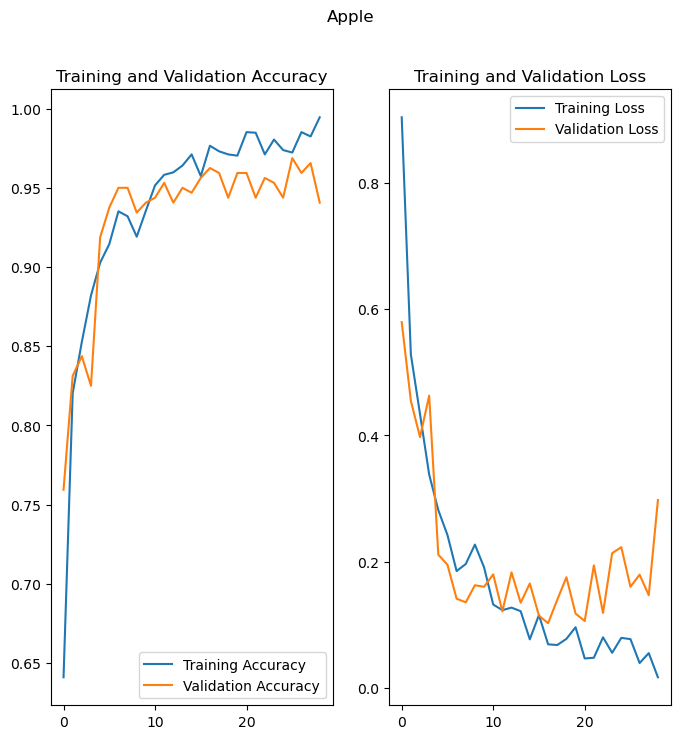

In [31]:
plt.figure(figsize=(8, 8))
plt.suptitle("Apple")
plt.subplot(1, 2, 1)
plt.plot(range(epochs_trained), acc, label='Training Accuracy')
plt.plot(range(epochs_trained), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(epochs_trained), loss, label='Training Loss')
plt.plot(range(epochs_trained), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Healthy
1/1 [==============================] - 1s 732ms/step
predicted label: Healthy


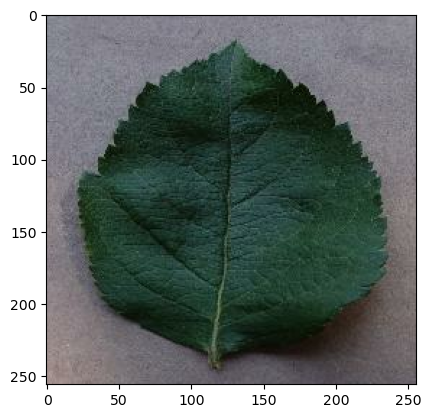

In [32]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [33]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 45ms/step


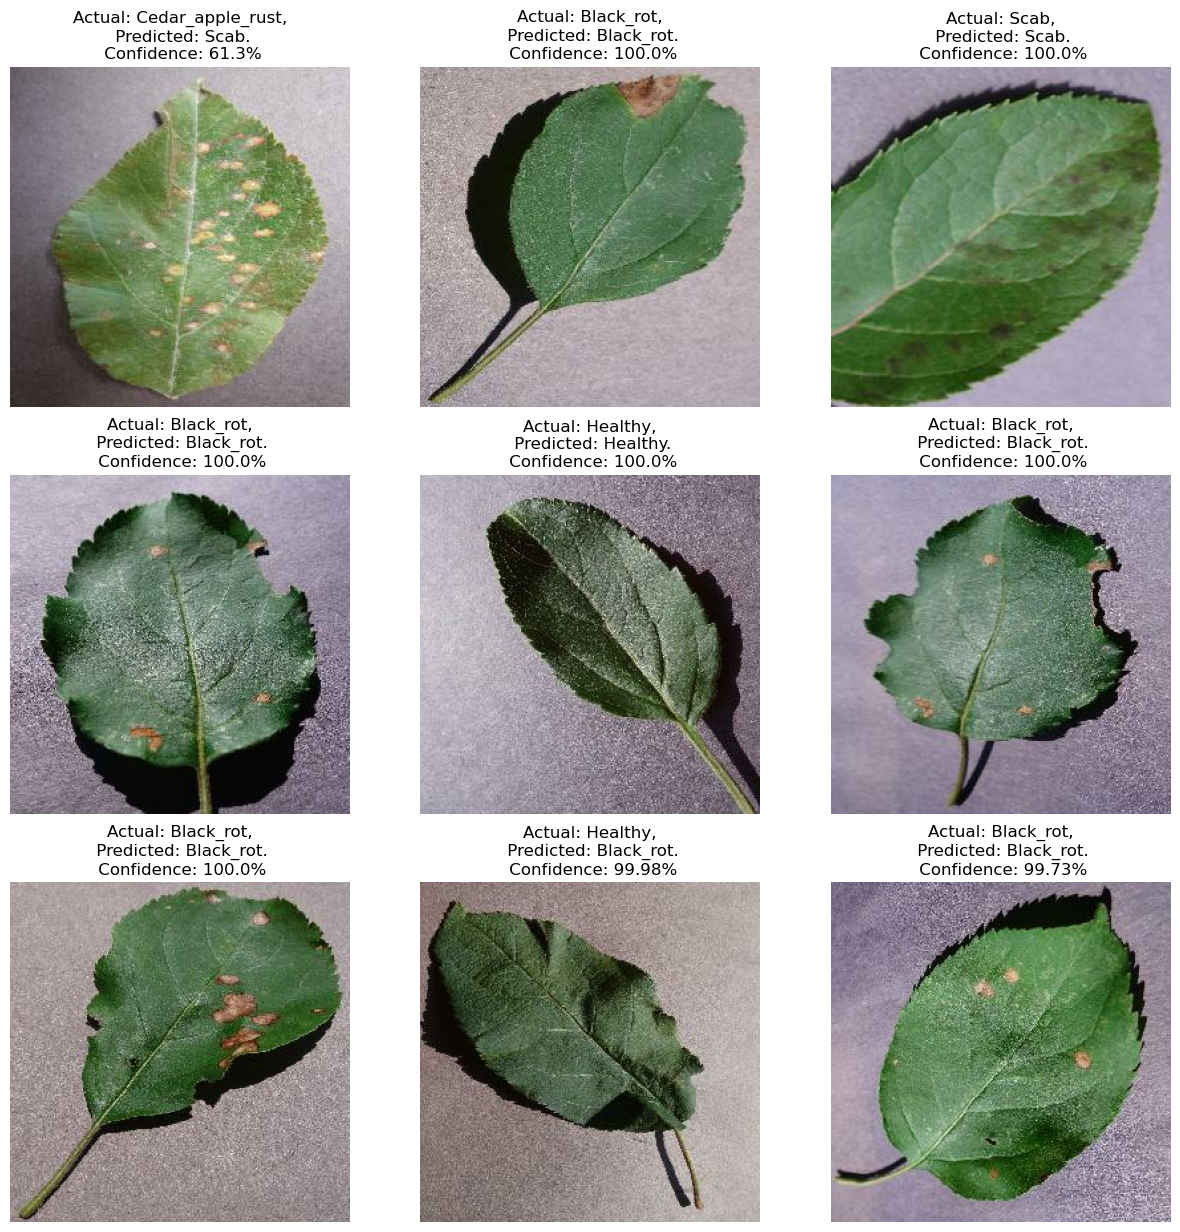

In [34]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [35]:
model.save(r'D:\College Stuff\TY\ML\MP\Main\Models\apple_cnn.h5')

In [36]:
import os
model.save("D:\College Stuff\TY\ML\MP\Main\Models\Apple")

INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Apple\assets


INFO:tensorflow:Assets written to: D:\College Stuff\TY\ML\MP\Main\Models\Apple\assets


In [37]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test_ds:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

1/1 [==============================] - 0s 390ms/step


In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Text(0.5, 1.0, 'Apple')

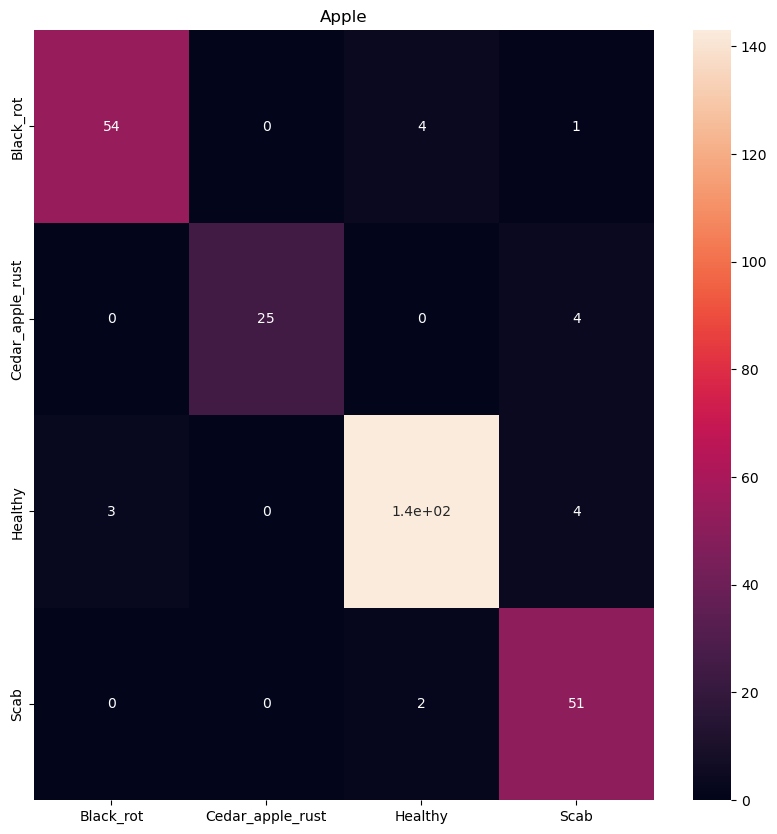

In [39]:
plt.figure(figsize=(10, 10))
apple_cm = confusion_matrix(y_true=correct_labels, y_pred=predicted_labels)
graph_labels = ['Black_rot', 'Cedar_apple_rust', 'Healthy', 'Scab']
sns.heatmap(apple_cm, annot = True, xticklabels=graph_labels, yticklabels=graph_labels)
plt.title("Apple")

In [40]:
apple_cm

array([[ 54,   0,   4,   1],
       [  0,  25,   0,   4],
       [  3,   0, 143,   4],
       [  0,   0,   2,  51]], dtype=int64)

In [41]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [42]:
f1_val = f1_score(y_true=correct_labels, y_pred=predicted_labels, average = None)
print("F-1 Scores: ", f1_val)

F-1 Scores:  [0.93103448 0.92592593 0.95652174 0.90265487]
